# **DnD Class Predictor**
## *Based on character stats, did the character multiclass?*

### **Preface:**
Dungeons and Dragons is a high fantasy tabletop role-playing game. Each player creates their own character to join in on a campaign (series of adventures). Every character has a class which influences their skills, abilities, items they can use etc. Some players like to optimize their character builds by multiclassing. 

Multiclassing is when a player decides to take a level in another class as opposed to the one they personalize your character, or to gain new abilities. Still, it can also be detrimental as it will take longer to gain abilities in the original chosen class. To simplify the DnD class predictor, I will be making a binary classifier that predicts whether or not a character has multiclassed based on their character sheet data.

### Before model building:
Some exploratory data analysis was done in Tableau. Click [here](https://public.tableau.com/app/profile/louisa.reilly/viz/dnd5e_char/DnD_Char?publish=yes) to see the sheets and interactive dashboard. The dataset was a bit messy, so some data cleaning and processing was done in a separate jupyter notebook. Click [here](https://github.com/geeselouise/classy_dnd/blob/main/char_data_processing.ipynb) to view the notebook.

In [15]:
import pandas as pd
import numpy as np
#data viz 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler


In [2]:
mc = pd.read_csv('~/Documents/GitHub/classy_dnd/dnd_chars_cleaned.csv')

In [3]:
mc.head()

,Unnamed: 0,background,justClass,level,feats,HP,AC,Str,Dex,Con,...,castWis,castCon,castDex,castStr,simpleWeapon,martialWeapon,rangedWeapon,num_feats,num_spells,multiClass
0,0,Knight,Warlock,4,Fighting Initiate,29,14,9,16,12,...,0,0,0,0,1,1,0,1,8,0
1,1,Knight,Warlock,1,Fighting Initiate,9,13,10,15,13,...,0,0,0,0,1,0,0,1,0,0
2,2,Knight,Warlock,3,NaN,28,12,11,14,14,...,0,0,0,0,1,0,0,0,11,0
3,3,Knight,Sorcerer,4,NaN,20,11,14,12,12,...,0,0,0,0,1,0,0,0,0,0
4,4,Urchin,Rogue,3,NaN,29,15,8,17,14,...,0,0,0,0,1,1,1,0,0,0


In [4]:
mc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9784 entries, 0 to 9783
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        9784 non-null   int64 
 1   background        9766 non-null   object
 2   justClass         9784 non-null   object
 3   level             9784 non-null   int64 
 4   feats             3066 non-null   object
 5   HP                9784 non-null   int64 
 6   AC                9784 non-null   int64 
 7   Str               9784 non-null   int64 
 8   Dex               9784 non-null   int64 
 9   Con               9784 non-null   int64 
 10  Int               9784 non-null   int64 
 11  Wis               9784 non-null   int64 
 12  Cha               9784 non-null   int64 
 13  skills            9776 non-null   object
 14  weapons           9644 non-null   object
 15  castingStat       9784 non-null   object
 16  processedRace     9596 non-null   object
 17  processedSpell

### Removing superfluous/ unprocessed features
Some of the features that I included after the initial cleaning have not been processed, such as background, processedRace, and justClass. Other features have been converted to a numeric format, e.g. processedWeapons, skills, and casting stats. There is already categories that encompass level (levelgroup), feats (num_feats), and processedSpells (num_spells). Dummy variables have been created for skills, castingStat, and weapon type (simple, melee, and ranged).

In [5]:
mc.drop(['Unnamed: 0', 'background', 'feats', 'weapons', 'skills',
         'castingStat' ,'processedWeapons', 'processedSpells', 'processedRace', 'justClass', 
        'levelGroup'], axis=1, inplace=True)

### Train Test split:
The DnD Character stats dataset is split into a training and testing set. 80/20. Each of the numeric values are visualized through a pairplot that takes a really long time to load and is difficult to read without zooming in. Probably should make this with less features.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(mc.iloc[:, 0:-1], mc.iloc[:, -1], 
                                                    test_size = 0.2, random_state=42)


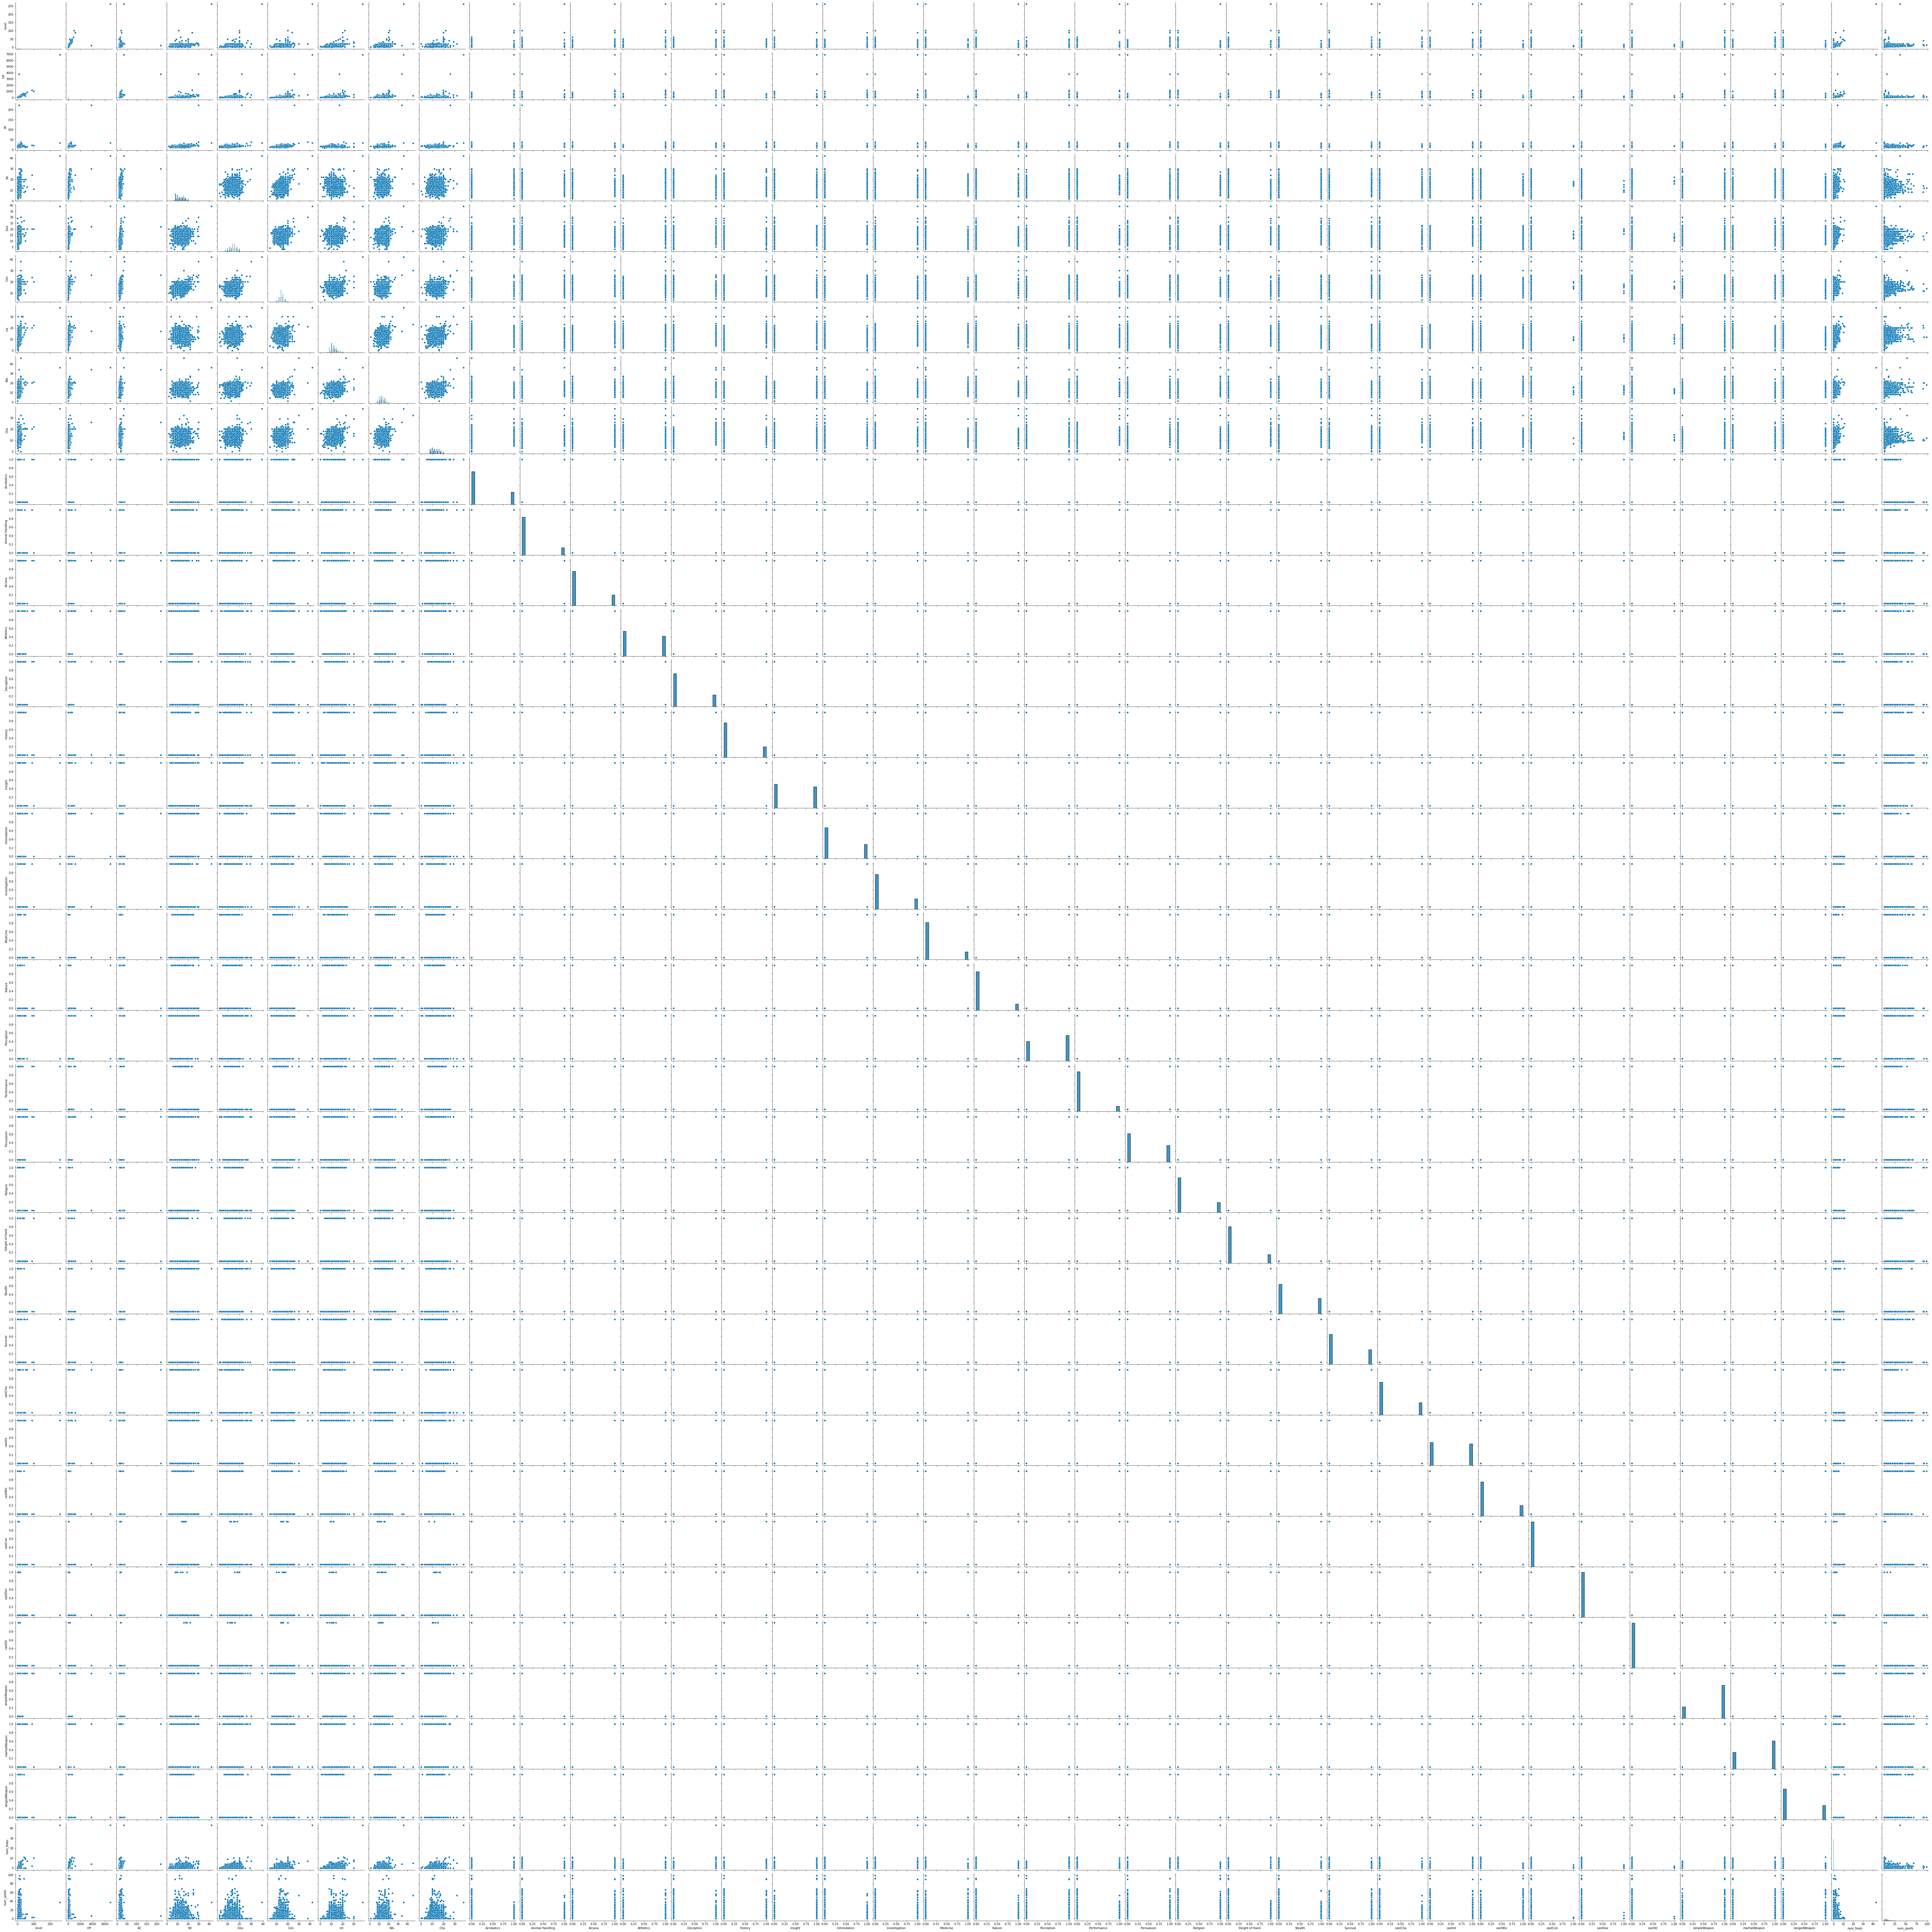

In [7]:
sns.pairplot(x_train)
#well this is hard to read

## 1st model: Logistic Regression
A logistic regression model is created for our binary classification problem. To reiterate, it is trying to predict if a character is multiclassed (1) or just using its base class (0).

In [8]:
lr_mc = LogisticRegression()
lr_mc.fit(x_train, y_train)
lr_mc.score(x_train, y_train)
#wow this score is not bad, but let's take a closer look.
# the multiclass group is much smaller than the base class group.

C:\Users\louisa\anaconda3\envs\redline\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8866743324389932

In [11]:
lr_mc.score(x_test, y_test)
# hmmm this is very suspicious. I thought it would do worse

0.8972917731221257

In [12]:
confusion_matrix(y_test, lr_mc.predict(x_test))
#just as i thought. 
#the positive class (multiclass characters) is not being predicted well

array([[1730,   23],
       [ 178,   26]], dtype=int64)

In [13]:
#hmm how is our f-1 score?
#well that is not a total failure, but still not great
f1_score(y_test, lr_mc.predict(x_test))

0.20553359683794467

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, lr_mc.predict_proba(x_test)[:,1])

ROC AUC score =  0.775902374640672


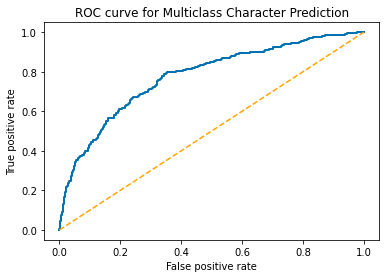

In [18]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='orange',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Multiclass Character Prediction');
print("ROC AUC score = ", roc_auc_score(y_test, lr_mc.predict_proba(x_test)[:,1]))

### **Conclusions**
More feature engineering needs to be done. More specifically, I will need to adjust the class weights so the positive class is weighted more heavily. If that does not work, then I could try oversampling from the positive class, and undersampling from the negative class. I also plan to compare other classification algorithms, such as SVM, RF, and XGboost.